In [1]:
from pathlib import Path

data_path = Path('data/train_val_test-WITH_POSTS/train_anonymized-WITH_POSTS.json')
data_path.exists()

True

In [2]:
import json

with open(data_path) as f:
    data = json.load(f)

In [36]:
from itertools import chain, combinations

def iter_json_sample(data_):
    for sample in data_.values():
        annos = chain(*sample['Annotations'].values())
        emos = {anno['Emotion'] for anno in annos if anno['Emotion'] != 'NA'}
        for emo1, emo2 in combinations(emos, 2):
            yield emo1, emo2

In [5]:
from data_preprocess import EMO_LIST

EMO_LIST

['anger', 'disgust', 'fear', 'joy', 'sadness', 'trust', 'anticipation']

In [43]:
n_emos = len(EMO_LIST)
emo2idx = dict(zip(EMO_LIST, range(n_emos)))
emo2idx

{'anger': 0,
 'disgust': 1,
 'fear': 2,
 'joy': 3,
 'sadness': 4,
 'trust': 5,
 'anticipation': 6}

In [76]:
import numpy as np

emo_combs = np.zeros([n_emos, n_emos])

for emos in iter_json_sample(data):
    i, j = map(emo2idx.get, emos)
    emo_combs[i][j] += 1
    emo_combs[j][i] += 1

emo_combs

array([[  0., 146., 263.,  30., 198.,  19., 300.],
       [146.,   0., 105.,  13.,  78.,  12., 112.],
       [263., 105.,   0.,  52., 227.,  67., 550.],
       [ 30.,  13.,  52.,   0.,  27.,  22.,  80.],
       [198.,  78., 227.,  27.,   0.,  21., 220.],
       [ 19.,  12.,  67.,  22.,  21.,   0.,  74.],
       [300., 112., 550.,  80., 220.,  74.,   0.]])

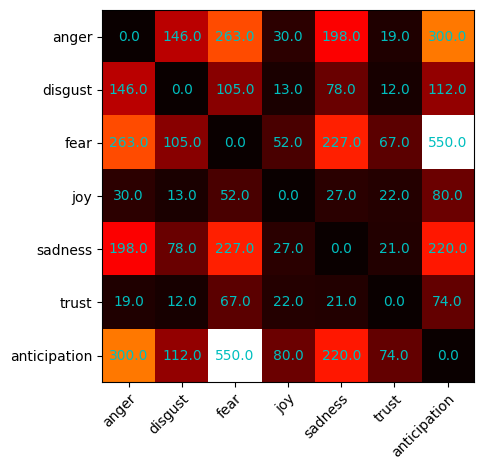

In [77]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()

ax.imshow(emo_combs, cmap='hot')
ax.set_xticks(np.arange(n_emos), labels=EMO_LIST)
ax.set_yticks(np.arange(n_emos), labels=EMO_LIST)

plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

for i in range(n_emos):
    for j in range(n_emos):
        ax.text(j, i, emo_combs[i, j], ha='center', va='center', color='c')

fig.tight_layout()

In [6]:
from itertools import chain

def iter_json_data(data_):
    for sample in data_.values():
        annos = chain(*sample['Annotations'].values())
        emos = {anno['Emotion'] for anno in annos if anno['Emotion'] != 'NA'}
        for emo in emos:
            yield emo

In [7]:
emo_freq = dict.fromkeys(EMO_LIST, 0)

for emo in iter_json_data(data):
    emo_freq[emo] += 1

emo_freq

{'anger': 470,
 'disgust': 192,
 'fear': 765,
 'joy': 134,
 'sadness': 360,
 'trust': 99,
 'anticipation': 873}

In [156]:
data_dict = {'input': [], 'summary': []}
instr = 'Generate a summary of what triggered {} in this post: {}'
emo_cnt = dict.fromkeys(EMO_LIST, 0)
emo_list = set(EMO_LIST)
MAX_SIZE = min(emo_freq.values())

for sample in data.values():
    annos = chain(*sample['Annotations'].values())
    annos = list(filter(lambda a: a['Emotion'] in emo_list, annos))
    anno = min(annos, key=lambda a: emo_freq[a['Emotion']], default=None)
    if anno is not None:
        emo = anno['Emotion']
        data_dict['input'].append(instr.format(emo, sample['Reddit Post']))
        data_dict['summary'].append(anno['Abstractive'])
        emo_cnt[emo] += 1
        if emo_cnt[emo] == MAX_SIZE:
            emo_list.remove(emo)

In [160]:
for i in range(10):
    print(data_dict['input'][i], f'[SUMMARY]{data_dict["summary"][i]}', sep='\n')
    print('\n')

Generate a summary of what triggered sadness in this post: In my area we have a super high vaccination rate. In the sf Metro area we have 65 fully vaccinated, and some parts of it like sf have 68.9 fully vaccinated of whole population. And yet the delta is still surging here. The cdc just said in areas with high transmission masks should be mandated again and I feel completely hopeless. It's so far unknown if the bay area will reimplement masks but I'm sure they will. It's been close too 2 weeks since LA reinstated masks and the cases are still exploding there which is pretty hopeless. I can just see another lockdown coming maybe in the winter.
[SUMMARY]The person feels defeated and without expectations of having to bear wearing masks again.


Generate a summary of what triggered anticipation in this post: Basically I looked at the Bloomberg tracker and saw that the USA will take another *8 months* to reach herd while Canada will only take four more *weeks*. I have a super close friend

## Explore Balanced Dataset Properties

In [1]:
import json
from pathlib import Path

data_path = Path('data/train_val_test-WITH_POSTS/train_anonymized-WITH_POSTS.json')
assert data_path.exists()

with open(data_path) as f:
    raw_data = json.load(f)

In [2]:
from itertools import chain
from data_preprocess import EMO_LIST

emo_freq = {
    'anger': 470,
    'disgust': 192,
    'fear': 765,
    'joy': 134,
    'sadness': 360,
    'trust': 99,
    'anticipation': 873
}
data_dict = {'post': [], 'emo': [], 'summary': []}
emo_cnt = dict.fromkeys(EMO_LIST, 0)
valid_emos = set(EMO_LIST)
MAX_SIZE = min(emo_freq.values())

for sample in raw_data.values():
    annos = chain(*sample['Annotations'].values())
    annos = list(filter(lambda a: a['Emotion'] in valid_emos, annos))
    anno = min(annos, key=lambda a: emo_freq[a['Emotion']], default=None)
    if anno is not None:
        emo = anno['Emotion']
        data_dict['emo'].append(emo)
        data_dict['post'].append(sample['Reddit Post'])
        data_dict['summary'].append(anno['Abstractive'])
        emo_cnt[emo] += 1
        if emo_cnt[emo] == MAX_SIZE:
            valid_emos.remove(emo)

In [45]:
trust_summ = [
    data_dict['summary'][i] for i, emo in enumerate(data_dict['emo'])
    if emo == 'trust'
]

In [47]:
print(*[*filter(lambda s: 'help' in s, trust_summ)][:10], sep='\n\n')

I trust that the vaccines will do their job and help end the pandemic.

I trust that people here have knowledge they are willing to share that can help me make choices that won't put my loved ones at risk of catching Covid.

I trust scientific evidence and know that it will help relieve my anxiety about catching Covid and with it, I will be able to lesson my obsessive behaviors. 

I know that taking these vitamins and minerals will help my body fight this virus and I trust that my immune system will get a boost. 

I trust that someone here can tell me what the chances are that I have been re-infected. Which may help relief some of my fears. 

I trust that I will be able to get helpful advice and learn about others that have had similar experiences, which will likely ease my anxiety.

I trust that people here will give me good advice that will help me make a good decision on whether or not to get the vaccine.

I accept that double masking will be necessary and feel the recommendations h

In [3]:
from collections import Counter
import numpy as np

def get_emo_summ_vocab(tgt_emo):
    emo_summ = [
        summ for summ, emo in zip(data_dict['summary'], data_dict['emo'])
        if emo == tgt_emo
    ]
    vocab = Counter(chain(*[summ.split() for summ in emo_summ]))
    return emo_summ, vocab

for tgt_emo in EMO_LIST:
    _, vocab = get_emo_summ_vocab(tgt_emo)
    vocab_size = len(vocab)

    vocab = np.float32(list(vocab.values()))
    vocab_mean = vocab.mean()
    vocab_var = vocab.var()

    print(f'{tgt_emo:<14}vocab size: {vocab_size}, mean: {vocab_mean:.3f}, variance: {vocab_var:.3f}')

anger         vocab size: 858, mean: 3.191, variance: 62.215
disgust       vocab size: 770, mean: 3.235, variance: 67.112
fear          vocab size: 824, mean: 3.689, variance: 100.236
joy           vocab size: 635, mean: 3.030, variance: 61.172
sadness       vocab size: 788, mean: 3.268, variance: 84.759
trust         vocab size: 621, mean: 3.176, variance: 82.077
anticipation  vocab size: 863, mean: 3.169, variance: 80.889


In [5]:
EMO_LIST

['anger', 'disgust', 'fear', 'joy', 'sadness', 'trust', 'anticipation']

In [18]:
def get_emo_words(emo, k=20):
    _, vocab = get_emo_summ_vocab(emo)
    words, _ = zip(*vocab.most_common(k))
    return set(words)

In [78]:
k = 400
common_words = get_emo_words(EMO_LIST[0], k)

for emo in EMO_LIST[1:]:
    words = get_emo_words(emo, k)
    common_words = common_words.intersection(words)

len(common_words)

73

In [75]:
for emo in EMO_LIST:
    words = get_emo_words(emo)
    _, vocab = get_emo_summ_vocab(emo)
    unique = words - common_words
    cnt = {word: vocab[word] for word in unique}
    print(f'{emo:<12}: {cnt}')

anger       : {'annoyed': 30, 'was': 26, 'angry': 23}
disgust     : {'see': 20, 'disgusted': 64}
fear        : {'afraid': 36, 'apprehensive': 27}
joy         : {'was': 17, 'happy': 48}
sadness     : {'sad': 69}
trust       : {'help': 20, 'can': 17, 'trust': 67}
anticipation: {'if': 27, 'expect': 32}


In [80]:
def count_unique_words(k):
    print(f'{k=}')
    common_words = get_emo_words(EMO_LIST[0], k)

    for emo in EMO_LIST[1:]:
        words = get_emo_words(emo, k)
        common_words = common_words.intersection(words)

    for emo in EMO_LIST:
        words = get_emo_words(emo)
        _, vocab = get_emo_summ_vocab(emo)
        unique = words - common_words
        cnt = {word: vocab[word] for word in unique}
        print(f'{emo:<12}: {cnt}')
    print('-'*20)

In [84]:
for k in [50, 100, 150, 200, 300, 400, 500, None]:
    count_unique_words(k)

k=50
anger       : {'because': 26, 'was': 26, 'annoyed': 30, 'angry': 23, "I'm": 57}
disgust     : {'this': 21, 'people': 29, 'disgusted': 64, "I'm": 43, 'see': 20}
fear        : {'because': 36, 'afraid': 36, 'from': 27, 'apprehensive': 27, "I'm": 99}
joy         : {'because': 13, 'was': 17, "I'm": 37, 'happy': 48}
sadness     : {'because': 29, 'has': 21, 'sad': 69, "I'm": 69}
trust       : {'help': 20, 'will': 57, 'trust': 67, 'can': 17, 'from': 19, 'not': 16}
anticipation: {'if': 27, 'expect': 32, 'will': 26, 'from': 24}
--------------------
k=100
anger       : {'annoyed': 30, 'was': 26, 'angry': 23}
disgust     : {'disgusted': 64, 'see': 20, 'this': 21}
fear        : {'afraid': 36, 'apprehensive': 27}
joy         : {'was': 17, 'happy': 48}
sadness     : {'has': 21, 'sad': 69}
trust       : {'help': 20, 'will': 57, 'can': 17, 'trust': 67}
anticipation: {'if': 27, 'expect': 32, 'will': 26}
--------------------
k=150
anger       : {'annoyed': 30, 'was': 26, 'angry': 23}
disgust     : {

In [141]:
unique_vocab_size_hist = {emo: [] for emo in EMO_LIST}

def count_unique_vocab_size(k):
    common_words = get_emo_words(EMO_LIST[0], k)

    for emo in EMO_LIST[1:]:
        words = get_emo_words(emo, k)
        common_words = common_words.intersection(words)

    for emo in EMO_LIST:
        words = get_emo_words(emo)
        _, vocab = get_emo_summ_vocab(emo)
        unique = words - common_words
        cnt = {word: vocab[word] for word in unique}
        unique_vocab_size_hist[emo].append(len(cnt))

for k in [50, 100, 150, 200, 300, 400, None]:
    count_unique_vocab_size(k)

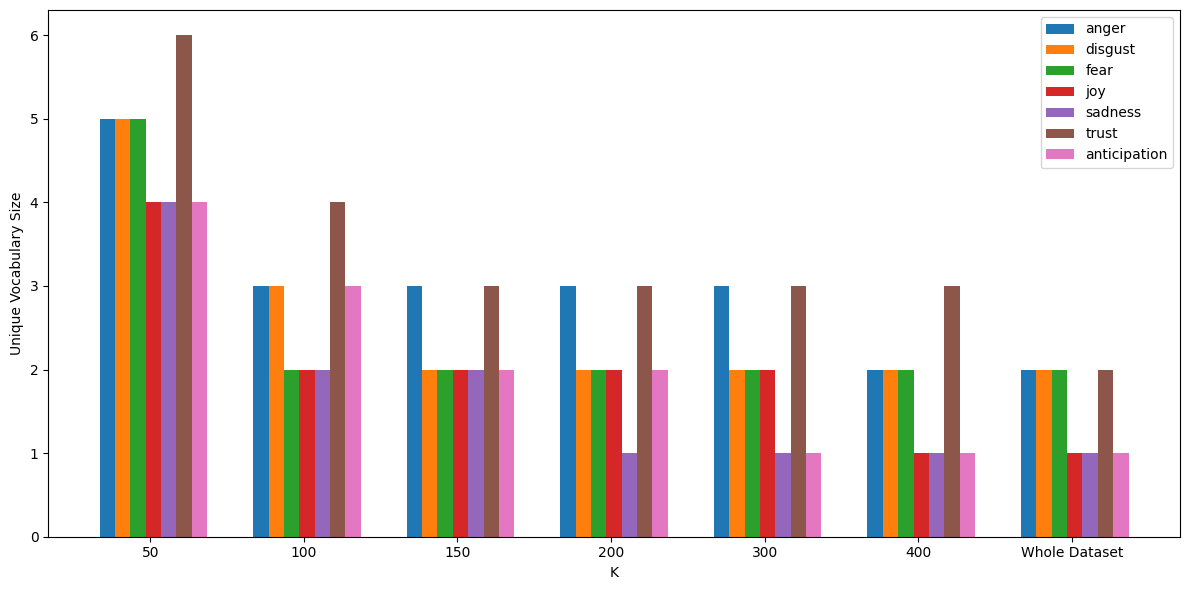

In [145]:
import matplotlib.pyplot as plt
import numpy as np

k_vals = [50, 100, 150, 200, 300, 400, 'Whole Dataset']
k_axis = np.arange(len(k_vals))
bar_width = 0.1
offset = 0.18
fig, ax = plt.subplots(figsize=[12, 6])

for dx, emo in enumerate(EMO_LIST):
    ax.bar(k_axis + dx * bar_width - offset, unique_vocab_size_hist[emo], width=bar_width, label=emo)

ax.legend(loc='upper right')
ax.set_xlabel('K')
ax.set_ylabel('Unique Vocabulary Size')
ax.set_xticks(k_axis + bar_width, k_vals)
# ax.set_title('Vocabulary Size of Top-K Most Frequent Unique Words')

fig.tight_layout()

In [17]:
for emo in EMO_LIST:
    _, vocab = get_emo_summ_vocab(emo)
    print(f'--------{emo}--------')
    words, freq = zip(*vocab.most_common(20))
    print(words)

--------anger--------
('to', 'the', 'I', 'and', 'that', 'my', "I'm", 'a', 'of', 'COVID', 'is', 'annoyed', 'are', 'because', 'was', 'have', 'me', 'angry', 'for', 'since')
--------disgust--------
('to', 'the', 'I', 'disgusted', 'that', 'and', 'my', "I'm", 'a', 'of', 'COVID', 'since', 'people', 'in', 'for', 'are', 'is', 'be', 'this', 'see')
--------fear--------
('I', "I'm", 'the', 'to', 'my', 'and', 'a', 'that', 'of', 'COVID', 'have', 'about', 'because', 'afraid', 'since', 'for', 'in', 'from', 'apprehensive', 'is')
--------joy--------
('I', 'to', 'the', 'and', 'that', 'happy', "I'm", 'a', 'my', 'of', 'be', 'am', 'is', 'was', 'with', 'in', 'are', 'COVID', 'about', 'because')
--------sadness--------
('I', 'to', 'the', 'and', 'that', 'my', 'sad', "I'm", 'of', 'COVID', 'a', 'have', 'me', 'because', 'since', 'be', 'in', 'am', 'has', 'for')
--------trust--------
('I', 'that', 'the', 'trust', 'and', 'to', 'will', 'my', 'me', 'be', 'it', 'of', 'help', 'a', 'from', 'have', 'can', 'COVID', 'in', 'n

In [59]:
for emo in EMO_LIST:
    summ, _ = get_emo_summ_vocab(emo)
    summ_size = np.float32([len(s.split()) for s in summ])
    print(f'{emo:<13}min={summ_size.min()} max={summ_size.max()} mean={summ_size.mean():.3f} std={summ_size.std():.3f}')

anger        min=8.0 max=51.0 mean=27.657 std=10.548
disgust      min=10.0 max=59.0 mean=25.162 std=9.141
fear         min=11.0 max=56.0 mean=30.707 std=9.255
joy          min=4.0 max=44.0 mean=19.434 std=8.912
sadness      min=7.0 max=51.0 mean=26.010 std=9.763
trust        min=7.0 max=47.0 mean=19.919 std=7.442
anticipation min=9.0 max=56.0 mean=27.626 std=10.305
